# Circuit Composition 

We study the composition of SSCx Dissemination circuits.

## Review of 2017 Release

# Analysis Suite

In this section we develop a suite of analyses for the circuits built at the Blue Brain Project.

In [1]:
import numpy as np
import pandas as pd
from neuro_dmt.analysis.circuit import BrainCircuitAnalysis
from neuro_dmt.models.bluebrain.circuit.model import BlueBrainCircuitModel
from neuro_dmt.models.bluebrain.circuit.adapter import BlueBrainCircuitAdapter

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi')


For the analysis suite, we can define components that will be common to all the
analyses we will collect in the suite.

The reference data we will use for validating the circuit consists of experimental
measurements made for each of the 6 cortical layers. Accordingly, we will make
measurements of the composition of the model circuit by layer.

For example, we will be computing several circuit composition phenomena by 
cortical layer.

In [2]:
from dmt.tk.parameters import Parameters

cortical_layers = [
    "L{}".format(layer)
    for layer in range(1, 7)
]
sscx_sub_regions = [
    "S1HL", "S1FL", "S1Sh", "S1Tr"
]
regions_and_layers = Parameters(
    pd.DataFrame({
        "region": [
            region
            for _ in cortical_layers
            for region in sscx_sub_regions],
        "layer": [
            layer
            for layer in cortical_layers
            for _ in sscx_sub_regions],
    })
)

For our analyses, we will plot model measurements along with reference data.
We will plot bars against layers for each of the 4 somatosensory cortex
sub-regions. 
Our predefined plotters allow us to do this quite conveniently.

In [3]:
from dmt.tk.plotting import Bars
from dmt.tk.plotting.multi import MultiPlot

def get_plotter(phenomenon): 
    return MultiPlot(
        mvar="region",
        plotter=Bars(
            xvar="layer",
            xlabel="Layer",
            yvar=phenomenon.label,
            ylabel=phenomenon.name,
            gvar="dataset")
    )

We have utility classes to provide an analysis report. 
Since all the analyses in our suite will be on the same circuit,
we can define a method to produce reports from analysis data,
and include circuit meta-data in this method.

In [4]:
from neuro_dmt.analysis.reporting import CircuitAnalysisReport

def circuit_analysis_report(**analysis_data):
    """
    Create a report for the data.
    """
    return CircuitAnalysisReport(
        animal="Wistar Rat",
        age="P12",
        brain_region="SSCx",
        uri="MockBlueBrainCircuitModel",
        **analysis_data
    )

We have validation reference data for cell densities and inhibitory cell ratios.
This data is from the somatosensory cortex hind-limb measured for each layer
in six individual rats. Since the same data was used to create cell density for 
all 4 sub-regions, we will use the same data to validate all 4 regions. To make
the data usable with our pre-defined analysis tool-chain, we define dataframes
with a column containing the region.

In [5]:
from dmt.data.observation import measurement
from neuro_dmt.data import rat

def _with_sscx_subregions(
    reference_dataframe):
    """
    Insert a column for SSCx subregion s.
    """
    return pd.concat([
        reference_dataframe.reset_index(
        ).assign(
            region=region
        ).set_index(
            ["region", "layer"]
        ) for region in sscx_sub_regions
    ])
cell_density_reference_data ={
    "DeFelipe2017": _with_sscx_subregions(
        rat.defelipe2017.summary_measurement.samples(1000)),
    "DeFelipe2014": _with_sscx_subregions(
        rat.defelipe2014.summary_measurement.samples(1000)),
    "meyer2010": _with_sscx_subregions(
        rat.meyer2010.samples(1000))
}

Our reference data now looks like,

In [6]:
cell_density_reference_data["DeFelipe2017"].head()

cell_density
region layer              
S1HL   L1     14828.731794
       L1     18691.219184
       L1     10840.561402
       L1     15419.618637
       L1      6997.256076

With the parameters, plotters, and reporters defined above, we can compose an
analysis.

In [7]:
from dmt.tk.phenomenon import Phenomenon
from neuro_dmt.analysis.circuit.composition.interfaces import\
    CellDensityAdapterInterface

cell_density_phenomenon = Phenomenon(
    "Cell Density",
    "Number of cells in a unit mm^3 volume.",
    group="Composition"
)
cell_density_analysis = BrainCircuitAnalysis(
    phenomenon=cell_density_phenomenon,
    AdapterInterface = CellDensityAdapterInterface,
    reference_data = cell_density_reference_data,
    measurement_parameters = regions_and_layers,
    plotter = get_plotter(cell_density_phenomenon),
    report = circuit_analysis_report
)

We can define other analyses in the same way, by just changing analysis 
components. 

In [8]:
class InhbitoryCellFractionAnalysisAdapterInterface(
    CellDensityAdapterInterface
):
    """
    Document circuit model adapter method to compute inhibitory cell fraction.
    """
    
    __measurement__ = "inhibitory_cell_fraction"
    
    def get_inhibitory_cell_fraction(self,
        circuit_model,
        **query):
        """
        The query may contain keys specifying the region in the circuit
        where the inhibitory cell fraction should be calculated.
        """
        pass

In [9]:
inhibitory_cell_fraction_phenomenon = Phenomenon(
    "Inhibitory Cell Fraction",
    "Fraction of inhibitory cells in a circuit.",
    group="Composition"
)

inhibitory_cell_fraction_reference_data ={
    "Ghobril2012": _with_sscx_subregions(rat.ghobril2012.samples(1000)),
    "LeFort2009": _with_sscx_subregions(rat.lefort2009.samples(1000)),
    "Beaulieu1992": _with_sscx_subregions(rat.beaulieu1992.samples(1000))
}
inhibitory_cell_fraction_analysis = BrainCircuitAnalysis(
    phenomenon = inhibitory_cell_fraction_phenomenon,
    AdapterInterface = InhbitoryCellFractionAnalysisAdapterInterface,
    reference_data = inhibitory_cell_fraction_reference_data,
    measurement_parameters = regions_and_layers,
    plotter = get_plotter(inhibitory_cell_fraction_phenomenon),
    report = circuit_analysis_report
)

We can use the analyses defined above to analyze any circuit
built at the BBP. We start by analyzing a mock circuit that /programmatically/
behaves exactly the same as a /real/ Blue Brain Project circuit model.
## Mock circuit
For developing our suite of analyses we will use a mock for the circuits built 
at BBP.

In [10]:
from neuro_dmt.models.bluebrain.circuit.mock.test.mock_circuit_light import\
    circuit_composition,\
    circuit_connectivity
from neuro_dmt.models.bluebrain.circuit.mock.circuit\
    import MockBlueBrainCircuitModel
mock_circuit_model = MockBlueBrainCircuitModel(
    circuit_composition,
    circuit_connectivity)

We can run our analysis step by step, first getting a measurement, and then
passing the result to the plotter.
Our adapter computes cell density in randomly sampled region of interest (ROI),
with the shape of cuboids. We can pass the number of ROIs to sample.

In [11]:
adapter = BlueBrainCircuitAdapter()
cell_density_measurement =\
    cell_density_analysis.get_measurement(
        mock_circuit_model,
        adapter,
        sample_size=10
)

The cell density measurement computed above is for the model circuit.
To analyze this measurement with the reference data, we need to append
reference data.

In [12]:
cell_density_measurement.head()

cell_density
dataset                   region layer              
MockBlueBrainCircuitModel S1HL   L1         408000.0
                                 L1          40000.0
                                 L1         256000.0
                                 L1         312000.0
                                 L1         168000.0

In [13]:
cell_density_analysis_data ={
    "MockBlueBrainCircuitModel": cell_density_measurement
}
cell_density_analysis_data.update(
    cell_density_reference_data
)

We can look at the statistical summary of the measurement.

For comparison against experimental data,
we consider the experimental data as *statistical models* with a mean 
and standard deviation of cell density per layer.
We use a normal statistical model to generate *samples* of cell density
measurements from the experimental data.

In [14]:
measurement.concat_as_summaries(cell_density_analysis_data).head()

cell_density                                        dataset layer region
          mean size            std                                        
0     231200.0   10  180565.039067  MockBlueBrainCircuitModel    L1   S1FL
1     218400.0   10  146207.766932  MockBlueBrainCircuitModel    L2   S1FL
2     254400.0   10  215515.506016  MockBlueBrainCircuitModel    L3   S1FL
3     201600.0   10  165324.730959  MockBlueBrainCircuitModel    L4   S1FL
4     207200.0   10  183107.011820  MockBlueBrainCircuitModel    L5   S1FL

The analysis produces figures using the plotters we have defined.

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/data/observation/measurement/__init__.py:495: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  for dataset, dataframe in data.items()])


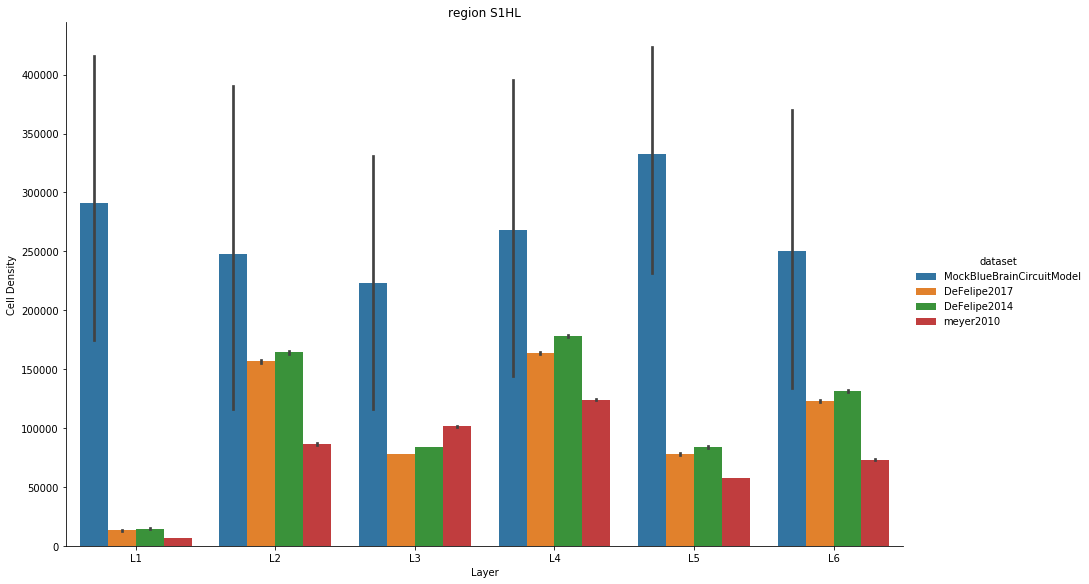

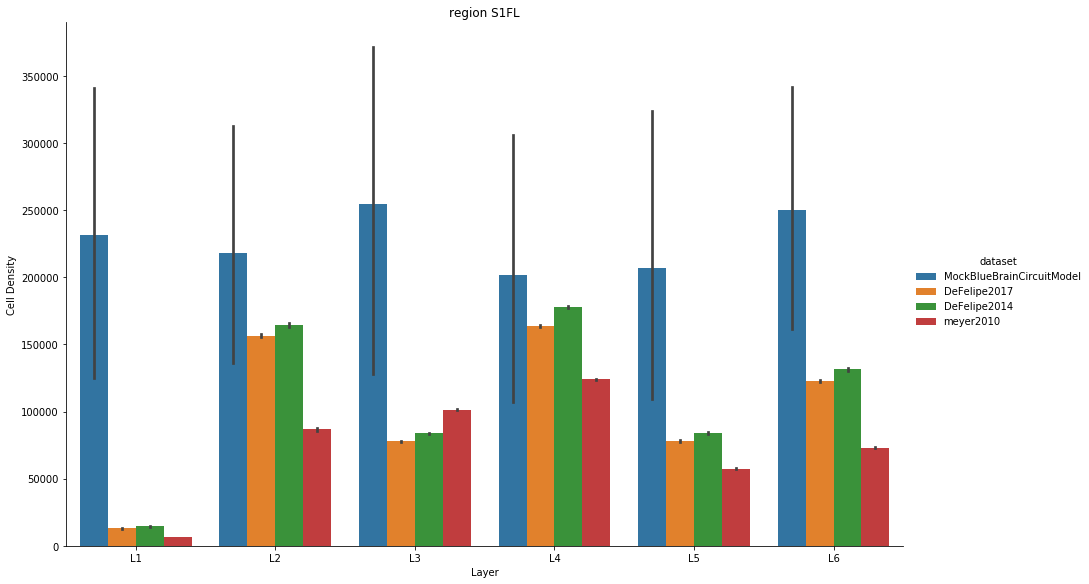

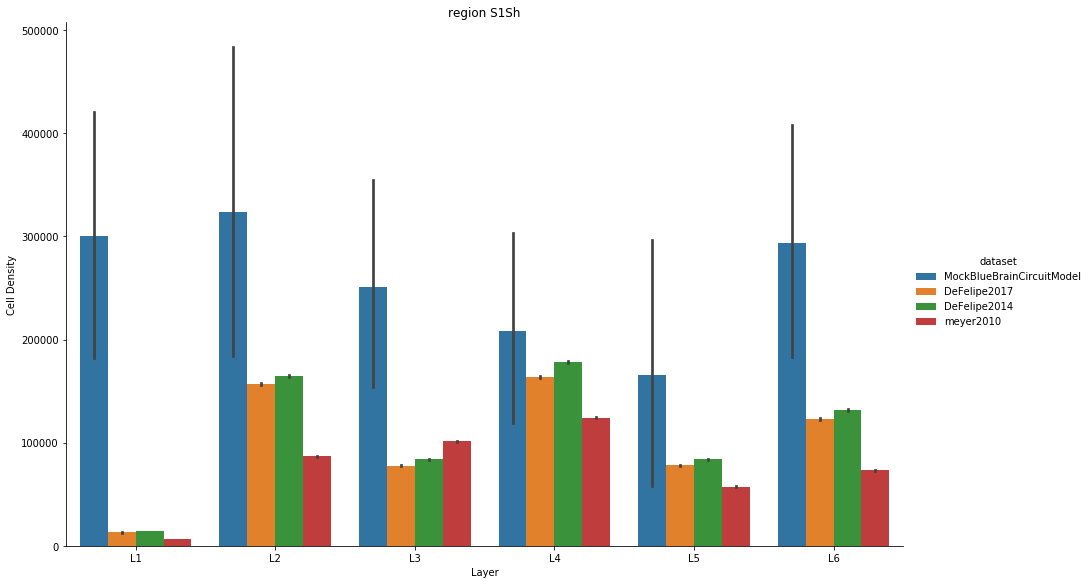

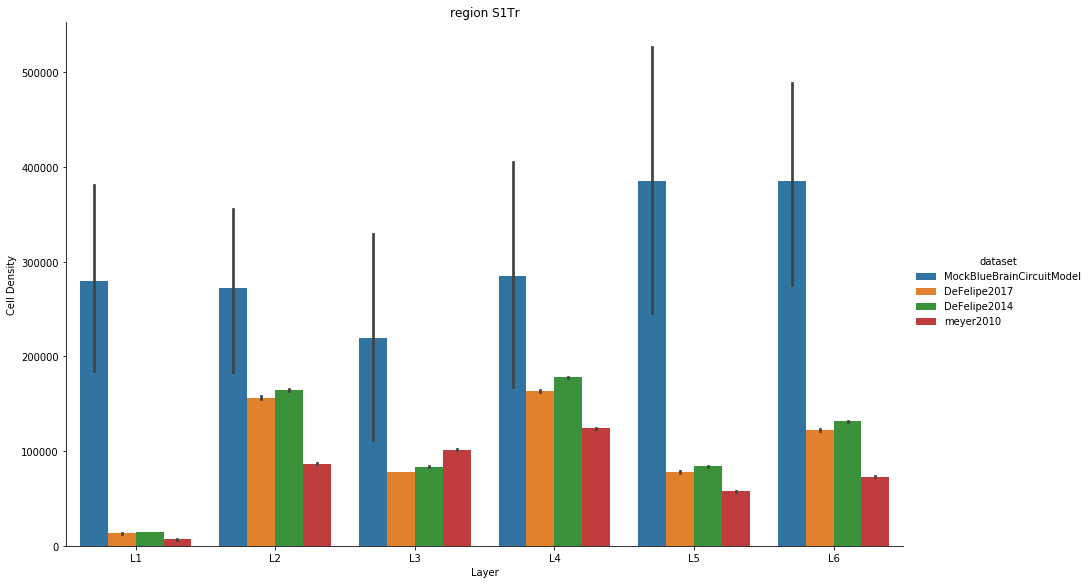

In [15]:
cell_density_figures =\
    cell_density_analysis.plotter.get_figures(
        cell_density_analysis_data,
        caption="Cell density by layer for sub-regions of the Rat SSCx"
)

We can call our analysis class can run the whole analyses.

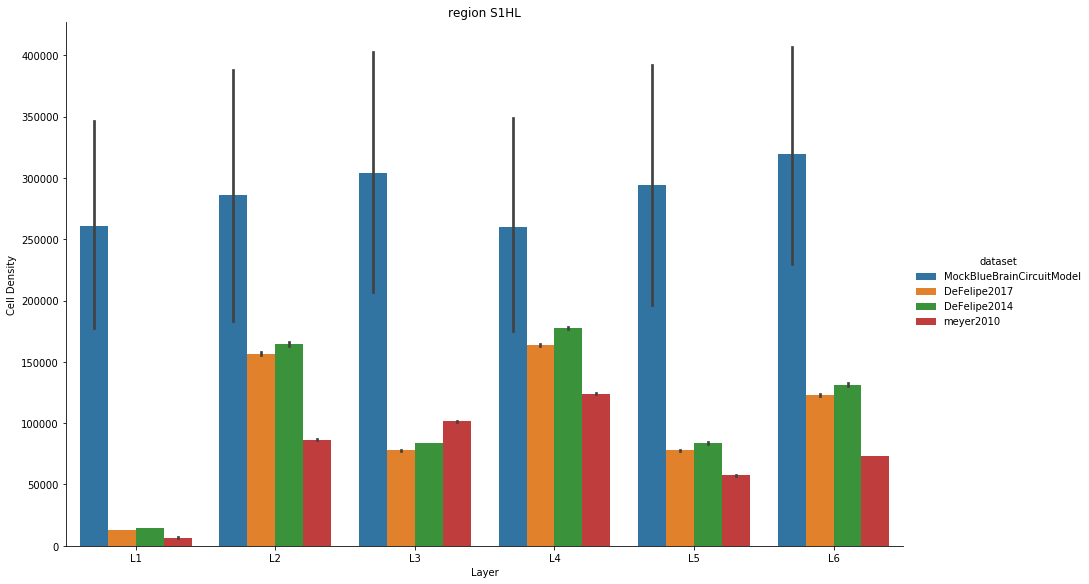

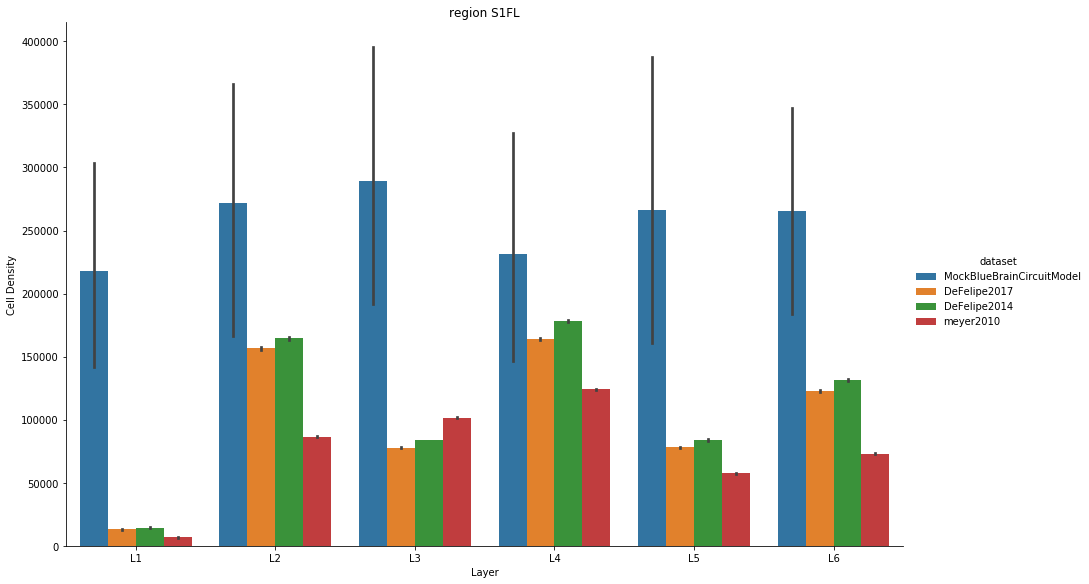

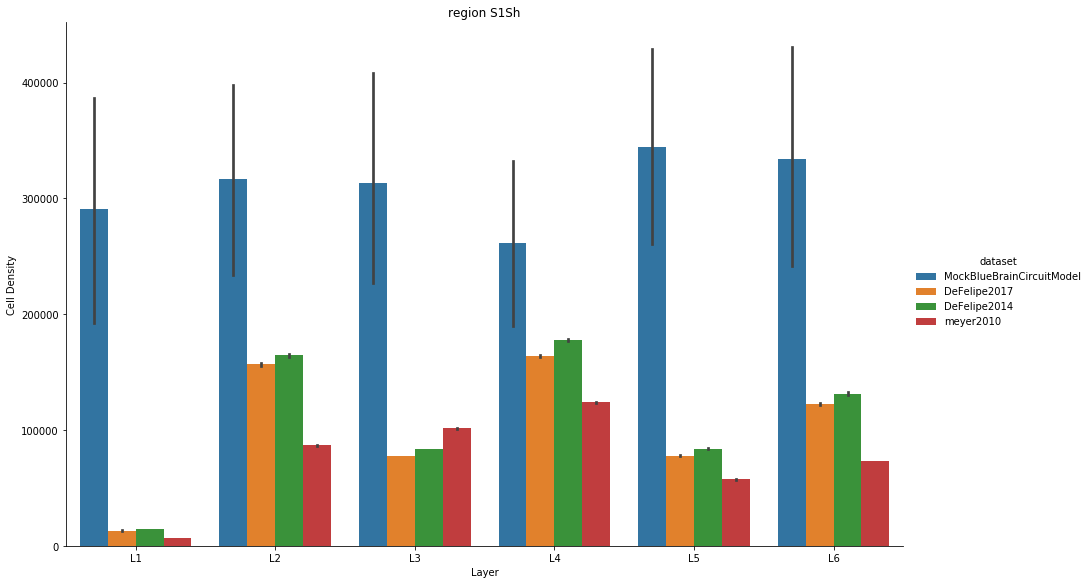

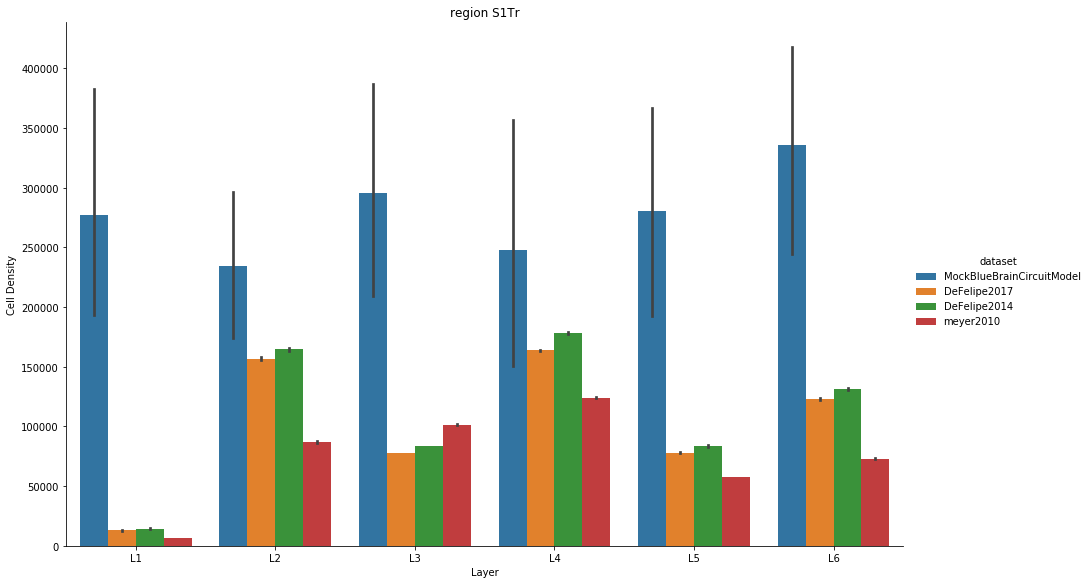

In [16]:
cell_density_analysis_report =\
    cell_density_analysis(
        mock_circuit_model,
        adapter
    )

The cell density analysis report generated above contains figures for each of the
SSCx sub-regions.

In [17]:
cell_density_analysis_report.figures

OrderedDict([('S1HL', <dmt.tk.plotting.figure.Figure at 0x12303a150>),
             ('S1FL', <dmt.tk.plotting.figure.Figure at 0x12406bd50>),
             ('S1Sh', <dmt.tk.plotting.figure.Figure at 0x124e6fb10>),
             ('S1Tr', <dmt.tk.plotting.figure.Figure at 0x124bc4b90>)])

In the `BlueBrainCircuitAdapter` we have documented how the cell densities were
measured, which is used along with the *phenomenon* analyzed to provide content
in the report.

In [18]:
print(cell_density_analysis_report.introduction)

Cell Density 
Number of cells in a unit mm^3 volume..


In [19]:
print(cell_density_analysis_report.methods)


                Cells were counted in a box with sides of length [50. 50. 50.] um.
                Each cube was centered at a cell that was randomly sampled from 
                a population described by a cell-query.
                


We have defined reporters to post the report as an HTML to a hard-disk.

In [20]:
import os
from neuro_dmt.analysis.reporting import CheetahReporter

reporter =\
    CheetahReporter(
        path_output_folder=os.path.join(os.getcwd(), "validations")
)
path_cell_density_analysis_report =\
    reporter.post(
        cell_density_analysis_report
)

The report was generated at `path_report`.

In [21]:
print(
    "Find the following in the analysis report: ",
    path_cell_density_analysis_report
)
os.listdir(path_cell_density_analysis_report)

Find the following in the analysis report:  /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/validations/cell_density/20191202/170653


['figures', 'report.html', 'cell_density.csv']

We next consider the analysis of the fraction of inhibitory cells in each layer.

In [22]:
inhibitory_cell_fraction_measurement =\
    inhibitory_cell_fraction_analysis.get_measurement(
        mock_circuit_model,
        adapter
)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py:384: RuntimeWarning: invalid value encountered in long_scalars
  / cells_roi.shape[0]


In [23]:
inhibitory_cell_fraction_measurement.head()

inhibitory_cell_fraction
dataset                   region layer                          
MockBlueBrainCircuitModel S1HL   L1                     0.071429
                                 L1                     1.000000
                                 L1                     0.106383
                                 L1                     1.000000
                                 L1                     0.272727

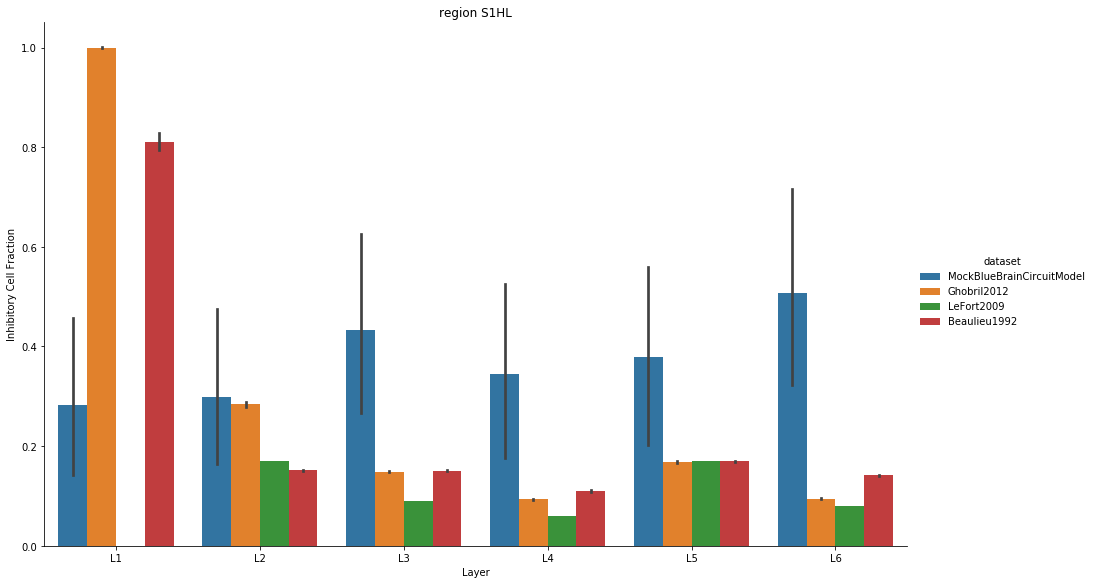

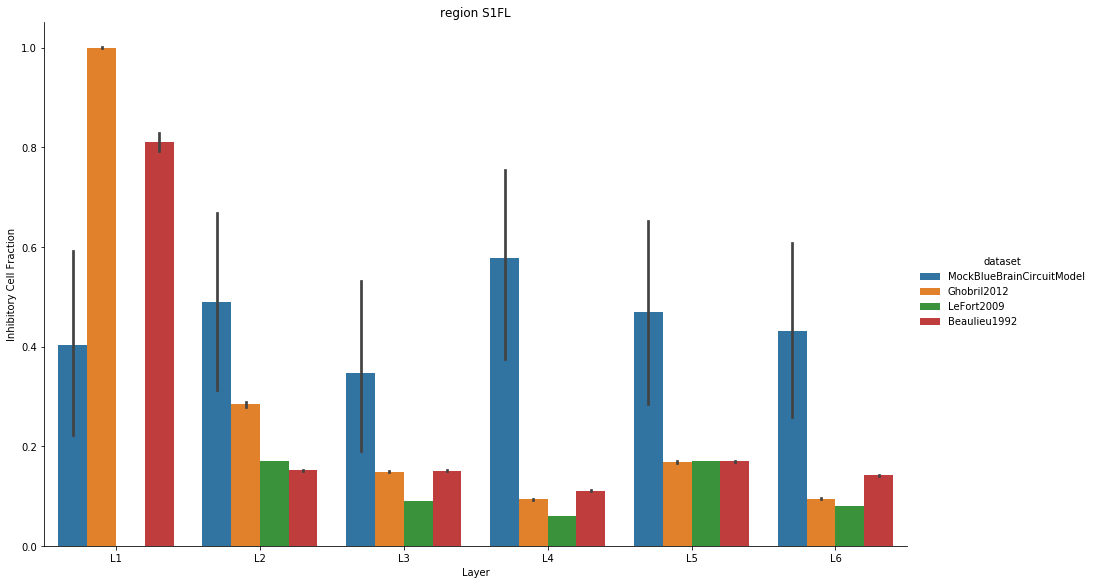

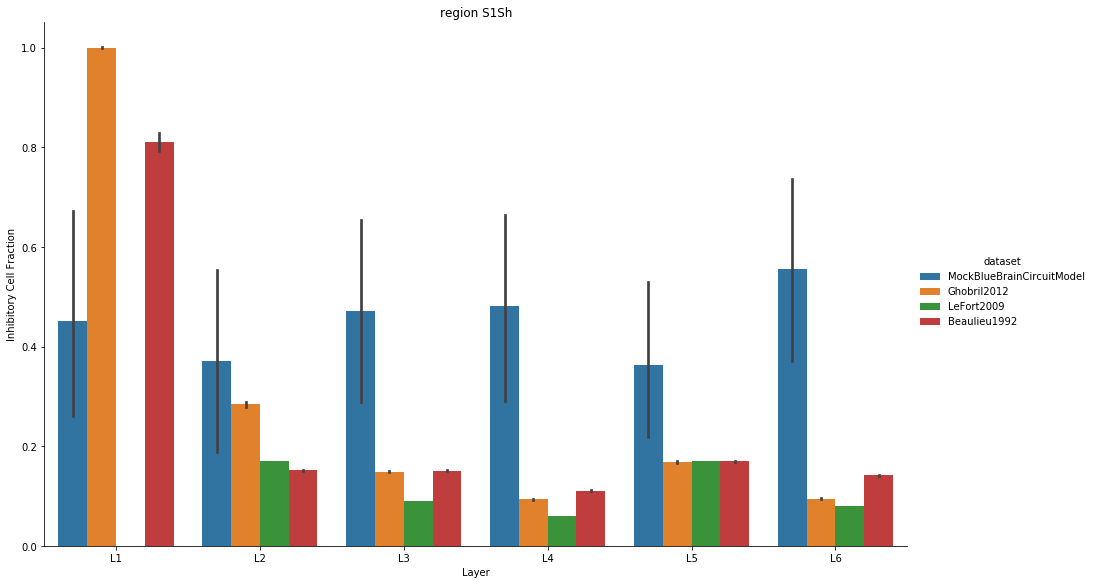

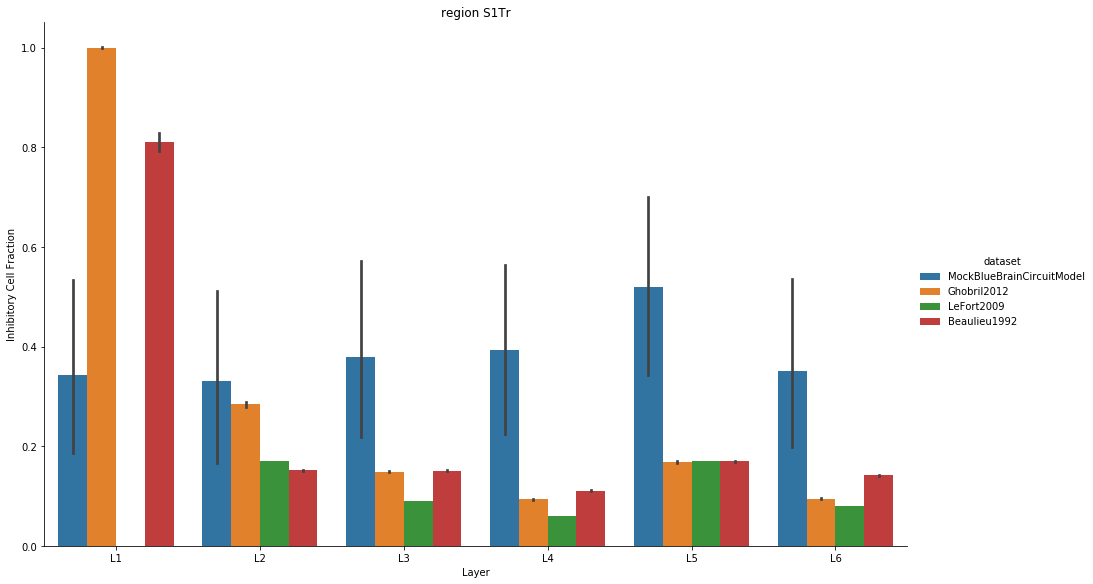

In [24]:
inhibitory_cell_fraction_analysis_report =\
    inhibitory_cell_fraction_analysis(
        mock_circuit_model,
        adapter
)

In [26]:
path_inhibitory_cell_fraction_analysis_report =\
    reporter.post(
        inhibitory_cell_fraction_analysis_report
)

In [27]:
path_inhibitory_cell_fraction_analysis_report

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/validations/inhibitory_cell_fraction/20191202/170733'